In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import yaml

sys.path.append("../")

%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.preprocessing import StandardScaler
from preprocessing.sliding_window import create_windowed_dataset
from model.hierarchical_self_attention_model import HSA_model_session_guided_window

### Data loading

In [3]:
data_path = '../data/processed/usc-had.csv'
df = pd.read_csv(data_path)

In [4]:
df.head()

,subject,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,activity
0,11,0.788496,0.429586,0.158079,-9.520525,1.719961,-0.391400,2
1,11,0.795364,0.425966,0.176379,-8.312029,-0.693527,0.414264,2
2,11,0.819400,0.454920,0.205661,-5.492205,-3.495776,1.622760,2
3,11,0.815967,0.454920,0.212981,0.147443,-5.509936,0.817096,2
4,11,0.840003,0.454920,0.209321,3.772932,-9.135425,-0.794232,2


In [5]:
FEATURES = ['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z']
LABEL = 'activity'

In [6]:
df = df.fillna(0)
scaler = StandardScaler()
df[FEATURES] = scaler.fit_transform(df[FEATURES])

In [7]:
hyperparameters = yaml.load(open('../configs/metadata.yaml', mode='r'), Loader=yaml.FullLoader)

metadata = yaml.load(open('../configs/metadata.yaml', mode='r'), Loader=yaml.FullLoader)['uschad_preprocess']

In [8]:
# metadata_file

In [9]:
train_subject = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
val_subject = [11, 12]
test_subject = [13, 14]

In [10]:
train_df = df.loc[df['subject'].isin(train_subject)]
val_df = df.loc[df['subject'].isin(val_subject)]
test_df = df.loc[df['subject'].isin(test_subject)]

SLIDING_WINDOW_LENGTH = metadata['sliding_win_len']
SLIDING_WINDOW_STEP = metadata['sliding_win_stride']
N_WINDOW, N_TIMESTEP = metadata['n_window'], metadata['n_timestep']

# FEATURES = metadata['feature_list']

X_train, y_train = create_windowed_dataset(
    train_df, FEATURES, LABEL, window_size=SLIDING_WINDOW_LENGTH, stride=SLIDING_WINDOW_STEP)
X_val, y_val = create_windowed_dataset(
    val_df, FEATURES, LABEL, window_size=SLIDING_WINDOW_LENGTH, stride=SLIDING_WINDOW_STEP)
X_test, y_test = create_windowed_dataset(
    test_df, FEATURES, LABEL, window_size=SLIDING_WINDOW_LENGTH, stride=SLIDING_WINDOW_STEP)

X_train = X_train.reshape(
    (X_train.shape[0], N_WINDOW, N_TIMESTEP, len(FEATURES)))
X_val = X_val.reshape(
    (X_val.shape[0], N_WINDOW, N_TIMESTEP, len(FEATURES)))
X_test = X_test.reshape(
    (X_test.shape[0], N_WINDOW, N_TIMESTEP, len(FEATURES)))

y_train = tf.keras.utils.to_categorical(y_train)
y_val = tf.keras.utils.to_categorical(y_val)
y_test = tf.keras.utils.to_categorical(y_test)

In [11]:
# from preprocessing.utils import get_train_test_data


In [12]:
print(X_train.shape)
print(y_train.shape)

(2464, 15, 100, 6)
(2464, 13)


In [13]:
y_train_mid = np.repeat(np.expand_dims(y_train, axis=1), repeats=15, axis=1)
y_val_mid = np.repeat(np.expand_dims(y_val, axis=1), repeats=15, axis=1)
y_test_mid = np.repeat(np.expand_dims(y_test, axis=1), repeats=15, axis=1)

In [14]:
y_train_mid.shape

(2464, 15, 13)

In [15]:
hparam_file = open('../configs/hyperparameters.yaml', mode='r')
hyperparameters = yaml.load(hparam_file, Loader=yaml.FullLoader)
hparams = hyperparameters['HSA_model']
hparams['modality_indices'] = hparams['modality_indices']['uschad']
hparams['n_window'], hparams['n_timesteps'], hparams['n_features'], hparams['n_outputs'] = X_train.shape[1], X_train.shape[2], X_train.shape[3], y_train.shape[1]
hparams['n_outputs_window']=  y_train.shape[1]

## Training

In [16]:
tf.keras.backend.clear_session()
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
    
device_list = ['/gpu:'+str(i) for i in range(5, 8)]
strategy = tf.distribute.MirroredStrategy(devices=device_list)
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
with strategy.scope():
    model = HSA_model_session_guided_window(**hyperparameters['HSA_model']).get_compiled_model()

8 Physical GPUs, 8 Logical GPUs
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:5', '/job:localhost/replica:0/task:0/device:GPU:6', '/job:localhost/replica:0/task:0/device:GPU:7')
Number of devices: 3


In [17]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 15, 100, 6)] 0                                            
__________________________________________________________________________________________________
multi_window_encoder (MultiWind ((None, None, 64), ( 150144      input_1[0][0]                    
__________________________________________________________________________________________________
modality_encoder_block_1 (Modal (None, None, 64)     104000      multi_window_encoder[0][0]       
__________________________________________________________________________________________________
combined_sensor_self_attention_ ((None, 64), (None,  49856       modality_encoder_block_1[0][0]   
____________________________________________________________________________________________

In [18]:
checkpoint_filepath = "usc_checkpoints/cp-{epoch:04d}.ckpt"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                               save_weights_only=True,
                                                               verbose=1)

In [19]:
model.fit(X_train, [y_train_mid, y_train], batch_size=len(device_list) * 64, epochs=40, validation_data=(X_val, [y_val_mid, y_val]), use_multiprocessing=True,callbacks=[model_checkpoint_callback] )

Epoch 1/40
INFO:tensorflow:batch_all_reduce: 96 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/devic

In [20]:
pred_mid, pred_sess = model.predict(X_test, batch_size=len(device_list) * 64)

In [21]:
# labels_map = {1:'lying',2:'sitting',3:'standing',4:'walking',5:'running',6:'cycling',7:'Nordic walking',
#               11:'ascending stairs',12:'descending stairs',13:'vacuum cleaning',
#               14:'ironing', 18:'rope jumping'}
# class_names = list(labels_map.values())

In [22]:
print(classification_report(np.argmax(y_test, axis=1), np.argmax(pred_sess, axis=1)))

              precision    recall  f1-score   support

           1       1.00      0.59      0.74       135
           2       0.88      0.65      0.75        77
           3       0.95      0.55      0.69        64
           4       0.22      0.60      0.32        20
           5       0.15      0.83      0.25        18
           6       1.00      0.52      0.69        63
           7       0.14      0.29      0.19        14
           8       0.29      0.71      0.42        80
           9       0.22      0.04      0.07        50
          10       1.00      0.10      0.18       130
          11       0.12      0.12      0.12        25
          12       0.10      0.38      0.16        16

    accuracy                           0.45       692
   macro avg       0.51      0.45      0.38       692
weighted avg       0.73      0.45      0.47       692



In [23]:
print(classification_report(np.argmax(y_test, axis=1), np.argmax(pred_sess, axis=1)))

              precision    recall  f1-score   support

           1       1.00      0.59      0.74       135
           2       0.88      0.65      0.75        77
           3       0.95      0.55      0.69        64
           4       0.22      0.60      0.32        20
           5       0.15      0.83      0.25        18
           6       1.00      0.52      0.69        63
           7       0.14      0.29      0.19        14
           8       0.29      0.71      0.42        80
           9       0.22      0.04      0.07        50
          10       1.00      0.10      0.18       130
          11       0.12      0.12      0.12        25
          12       0.10      0.38      0.16        16

    accuracy                           0.45       692
   macro avg       0.51      0.45      0.38       692
weighted avg       0.73      0.45      0.47       692



In [24]:
# activity_map

<AxesSubplot:>

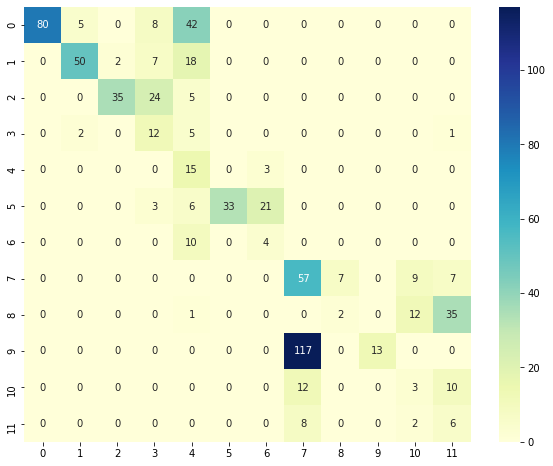

In [25]:
confm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(pred_sess, axis=1))
# activity_list = list(activity_map.values())
df_cm = pd.DataFrame(confm)
plt.figure(figsize = (10,8))
sns.heatmap(df_cm, annot=True, fmt='d', cmap="YlGnBu")

In [31]:
y_test_mid.shape

(692, 15, 13)

In [32]:
pred_mid.shape

(692, 15, 13)

In [36]:
print(classification_report(np.argmax(y_test_mid.reshape(-1, 13), axis=1), np.argmax(pred_mid.reshape(-1, 13), axis=1)))

              precision    recall  f1-score   support

           1       1.00      0.60      0.75      2025
           2       0.89      0.62      0.73      1155
           3       0.95      0.49      0.64       960
           4       0.19      0.57      0.29       300
           5       0.15      0.82      0.25       270
           6       1.00      0.53      0.69       945
           7       0.14      0.29      0.19       210
           8       0.30      0.73      0.43      1200
           9       0.21      0.03      0.06       750
          10       1.00      0.11      0.20      1950
          11       0.10      0.06      0.07       375
          12       0.11      0.48      0.18       240

    accuracy                           0.44     10380
   macro avg       0.50      0.44      0.37     10380
weighted avg       0.73      0.44      0.47     10380



<AxesSubplot:>

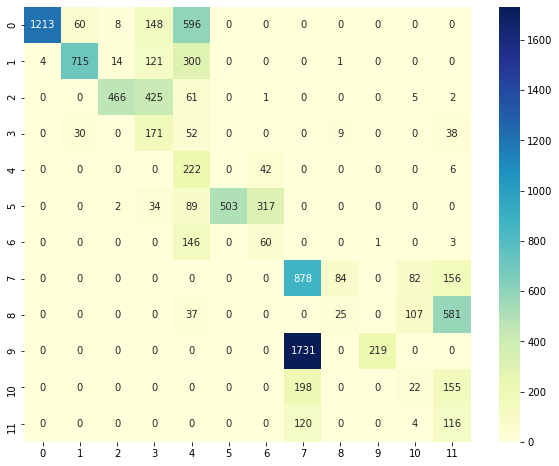

In [37]:
confm = confusion_matrix(np.argmax(y_test_mid.reshape(-1, 13), axis=1), np.argmax(pred_mid.reshape(-1, 13), axis=1))
# activity_list = list(activity_map.values())
df_cm = pd.DataFrame(confm)
plt.figure(figsize = (10,8))
sns.heatmap(df_cm, annot=True, fmt='d', cmap="YlGnBu")